In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

## Group Assignment
### Team Number: 17
### Team Member Names: Rachel, Pavel, Timo
### Team Strategy Chosen: ______RISKY____

In [2]:
# Define start and end dates for data
start_date = '2023-01-01'
end_date = '2023-10-31'

stocks = pd.read_csv('Tickers_Example.csv')
# Since there isn't a column name the first ticker becomes it and needs to be inserted back into the file
stocks.loc[len(stocks)] = list(stocks.columns)[0]
stock_lst = stocks[list(stocks.columns)[0]].tolist() 
# removes duplicates
stock_lst = list(set(stock_lst))

# Gets historical USD to CAD exchange rate data
usd_cad_tick = yf.Ticker('USDCAD=x')
usd_cad_hist = usd_cad_tick.history(start = start_date, end = end_date)
usd_cad_hist.index = pd.DatetimeIndex(usd_cad_hist.index).tz_localize(None, ambiguous='infer').tz_localize('UTC').date

# DataFrames to store stock historical close prices and volumes
stock_hists_close = pd.DataFrame()
stock_hists_vol = pd.DataFrame()

# Loop through each stock ticker to retrieve historical data and check restrictions
for stock in stock_lst:
    tick = yf.Ticker(stock)
    stock_hist = tick.history(start=start_date, end=end_date)
    stock_hist.index = pd.DatetimeIndex(stock_hist.index).tz_localize(None, ambiguous='infer').tz_localize('UTC').date
    # Filter stocks based on volume and currency criteria      
    if len(stock_hist) != 0 and (tick.history_metadata['currency'] == 'USD' or tick.history_metadata['currency'] == 'CAD'):
        add = True
        for mo in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']:
            if len(stock_hist.filter(like=f'2023-{mo}', axis=0)) >= 18:
                if stock_hist.filter(like=f'2023-{mo}', axis=0)['Volume'].sum() < 150000:
                    add = False
        if add:
            if tick.history_metadata['currency'] == 'USD':
                # Convert USD-denominated stock prices to CAD  
                stock_convert = pd.concat([stock_hist.Close, usd_cad_hist.Close], join = 'inner', axis = 1)
                stock_convert.columns = ['Close', 'Close_usd_cad']
                stock_hist['Close Cad'] = stock_convert['Close'] * stock_convert['Close_usd_cad']
                stock_hists_close[f"{stock} Close"] = stock_hist['Close Cad']
            else:
                stock_hists_close[f"{stock} Close"] = stock_hist['Close']
            stock_hists_vol[f"{stock} Volume"] = stock_hist['Volume']
stock_hists_close = stock_hists_close.dropna()
stock_hists_vol = stock_hists_vol.dropna()

stock_hists_close.head()


CELG: No timezone found, symbol may be delisted
RTN: No timezone found, symbol may be delisted
AGN: No timezone found, symbol may be delisted
MON: No timezone found, symbol may be delisted


,PG Close,LMT Close,PEP Close,ABBV Close,LLY Close,UNH Close,USB Close,RY.TO Close,BK Close,AMZN Close,...,UNP Close,UPS Close,T.TO Close,QCOM Close,BAC Close,PM Close,SHOP.TO Close,PYPL Close,PFE Close,ACN Close
2023-01-03,200.425721,634.884805,238.276717,211.621931,490.056241,695.157310,57.969780,122.739281,60.569191,116.363342,...,276.074086,228.572688,25.214359,142.464873,44.415906,131.888310,48.790001,101.123028,66.486766,360.714640
2023-01-04,203.007171,638.893127,239.710035,215.140117,491.657111,681.944924,60.282251,123.832161,62.587345,116.421282,...,280.644095,232.919639,25.520916,149.477482,45.635064,132.915977,50.610001,106.234082,65.573051,362.538276
2023-01-05,197.715715,630.816225,233.926818,211.907272,479.279839,653.136848,58.984098,123.467873,61.423041,112.088157,...,268.617185,225.459288,25.492176,144.596187,44.912034,130.547956,48.830002,102.850855,64.060430,349.084998
2023-01-06,203.546674,629.222918,240.537171,217.070925,487.336154,656.813351,60.142445,125.040092,62.731874,116.723626,...,281.984521,233.374007,25.884954,153.292807,45.611837,134.748542,49.560001,103.706124,66.050155,359.336991
2023-01-09,199.211513,604.663767,235.995827,208.759985,465.412966,650.852845,59.975380,125.970001,62.401264,117.369912,...,278.666529,234.768279,25.827473,150.921812,44.509437,131.974194,49.810001,103.558528,62.191170,362.036626


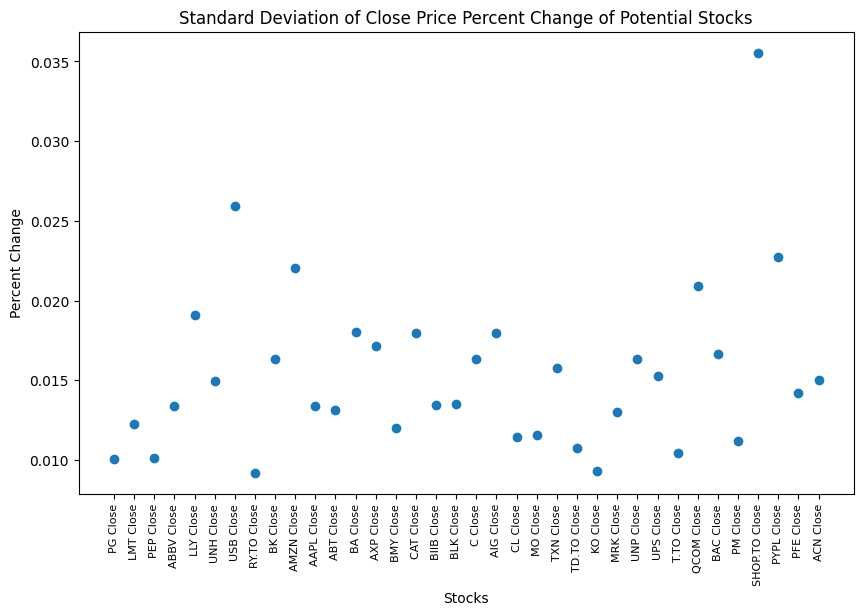

In [3]:
#Find std of close price percent change
stocks_std_series = stock_hists_close.pct_change().std()
stocks_std = stocks_std_series.to_dict() #Turn to dictionary

# Graph standard deviations
stock_names = list(stocks_std.keys())
stock_stds = list(stocks_std.values())
plt.figure(figsize=(10, 6))
plt.scatter(stock_names, stock_stds)
plt.xticks(rotation=90, fontsize=8)
plt.title('Standard Deviation of Close Price Percent Change of Potential Stocks')
plt.xlabel('Stocks')
plt.ylabel('Percent Change')
plt.show()


As we learned from Assignment 3, finding the standard deviation of the percent change of the stock’s closing prices shows the riskiness of the stock. This is because the higher the standard deviation is, the more the stock’s price is changing, meaning it is more volatile and risky. So, we took the standard deviations of the stocks to evaluate their riskiness, as we want to find the stocks with a high standard deviation to create a risky portfolio. From the graph, we can see that some stocks have higher standard deviations and thus larger fluctuations in price than others. These are stocks we would like to have in our portfolio, provided they are also positively correlated with each other, since that is another key point of creating a risky portfolio. 


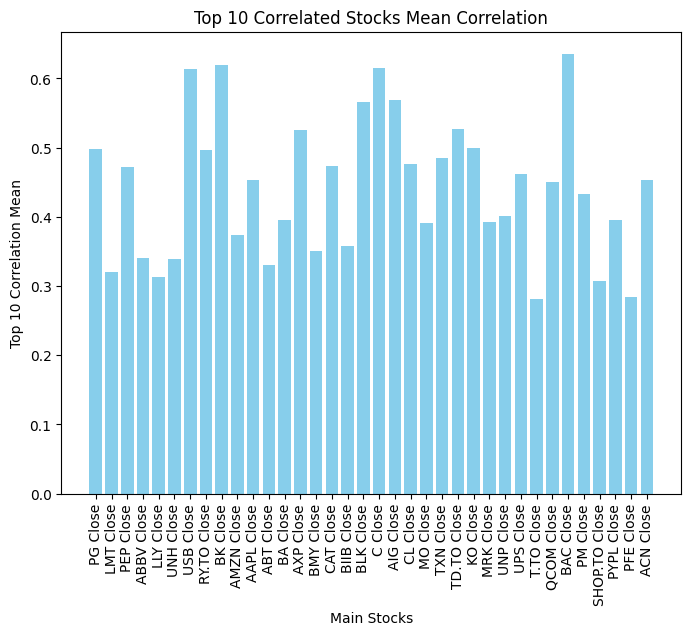

In [4]:
# Calculate correlation between stocks
corr_data = stock_hists_close.pct_change().corr()
# Determine top correlated stocks and their mean correlation
corr_dict = dict()
corr_stocks_dict = dict()

# Looping through each stock in the columns of the correlation data
for stock in list(corr_data.columns):
    stock_dict = dict() # Creating a dictionary to store correlations for each stock
    # Iterating through each row in the correlation data
    for row in list(corr_data.index):
        corr = corr_data[stock][row] # Getting the correlation value for the current stock and row
        # Storing correlated stocks (excluding self-correlation)
        if corr != 1:
            stock_dict[corr] = row # Storing correlation values as they key with the stock names as the values
    # Sorting and selecting the top 9 correlated stocks for the current stock
    skey_lst = sorted(list(stock_dict.keys()), reverse=True)[:9] 
    stock_lst = list()
    # Creating a list of stocks based on the selected correlations
    for key in skey_lst:
        stock_lst.append(stock_dict[key]) # Adding correlated stocks to the list
    # Calculating the average correlation for the current stock
    corr_dict[stock] = sum(skey_lst) / len(skey_lst)
    # Storing the top correlated stocks for each stock in a dictionary
    corr_stocks_dict[stock] = stock_lst

# The Stocks and there respective mean correlation
stocks = corr_dict.keys()
values = corr_dict.values()

# Creating bar graph
plt.figure(plt.figure(figsize=(8, 6)))
plt.bar(stocks, values, color='skyblue')

# Adding labels and title
plt.title('Top 10 Correlated Stocks Mean Correlation')
plt.xlabel('Main Stocks')
plt.xticks(rotation=90)
plt.ylabel('Top 10 Correlation Mean')

# Showing the plot
plt.show()

The correlation between stocks in a portfolio impacts the riskiness through diversification. When 2 stocks are positively correlated, it means that they tend to move in the same direction. If one stock grows or declines, stocks that are positively correlated are likely to follow suit. So, the higher the correlation between stocks, the riskier your portfolio will be since your stocks are likely to be gaining or losing value at the same time. Then, comparing the mean correlation between the top nine correlated stocks with each stock will give you the highest average correlation between those 10 stocks. Just as stated above, the higher the correlation, the riskier those 10 stocks are together because if one of them has a change in value the others are likely to have a similar change in value in the same direction. By using this in our code we are able to find the riskiest combination of 10 stocks, which when used in the same portfolio will mean that they will have the largest fluctuation in value. But even if stocks are correlated if the correlated stocks don't fluctuate a lot in value then they might not be the riskiest. Which is why we combine these calculations with std and moving mean to make sure the correlated stocks have large fluctuation in value.


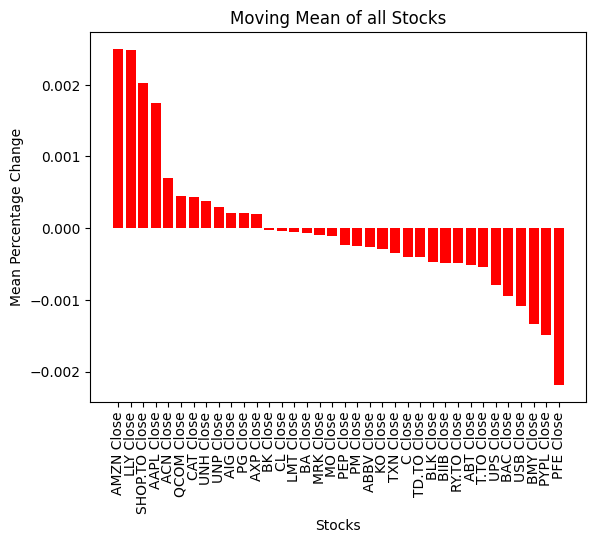

In [5]:
# Creates a sorted list of stocks with the 
def moving_avg(portfolio):
    pct_change_portfolio = portfolio.pct_change()
    pct_change_portfolio = pct_change_portfolio.dropna()
    mean_dict = {stock: pct_change_portfolio[stock].mean() for stock in pct_change_portfolio}
    sorted_mean_dict = dict(sorted(mean_dict.items(), key=lambda item: item[1], reverse=True))
    return sorted_mean_dict

mean = moving_avg(stock_hists_close)

#In a given list of stocks, the function finds a stock with the overall highest standard deviation,
# correlation with other stocks and moving mean
def choose_best(sorted_port,corr_dict, std):
    temp={}
    for stock in corr_dict: 
        temp[stock] = abs(sorted_port[stock] * corr_dict[stock] * std[stock])
    best = max(temp.values())
    for i in temp: 
        if temp[i] == best:
            return i


main_stock = choose_best(mean, corr_dict, stocks_std)
corr_stocks = corr_stocks_dict[main_stock]
corr_stocks.insert(0, main_stock)
corr_stocks # Final 10 Stocks
chosen_ticker_list = [] #List of tickers for final stocks

# plots a bar graph
stock_mean = mean.keys()
value_mean = mean.values()
plt.bar(stock_mean, value_mean, color='red')
plt.title('Moving Mean of all Stocks')
plt.xlabel('Stocks')
plt.xticks(rotation=90)
plt.ylabel('Mean Percentage Change')

# Showing the plot
plt.show()

The bar graph shows the companies that have the strongest general price movement. We believe within a given 5-day period a stock will follow the general trend, and thus we’ve calculated the moving average over a 10-month period. 
We then factor in standard deviation as well as correlation to find the stock that has the most synchronous, and strongest fluctuations in price with 9 other stocks, thereby amplifying the overall volatility of the portfolio. The cornerstone of this approach is the identification of a main stock that has the highest level of volatility, determined by analyzing of both its moving mean and standard deviation and the strength of positive correlations with the other stocks. Then the rest of the portfolio is made up of the top 9 correlated stocks to the main stock. This gives us the riskiest portfolio since all the stocks are positively correlated with each other and fluctuate significantly in value.

/var/folders/w3/dp8dqs513zj2zq24rt4723y40000gn/T/ipykernel_40497/2781582302.py:27: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  close_pct = close.pct_change()


Maximum portfolio value achieved: 837196.573858492
Corresponding optimal weights: 0    0.174537
1    0.194260
2    0.086204
3    0.080257
4    0.104961
5    0.089214
6    0.058651
7    0.075996
8    0.075769
9    0.060151
dtype: float64
Sum: 1.0


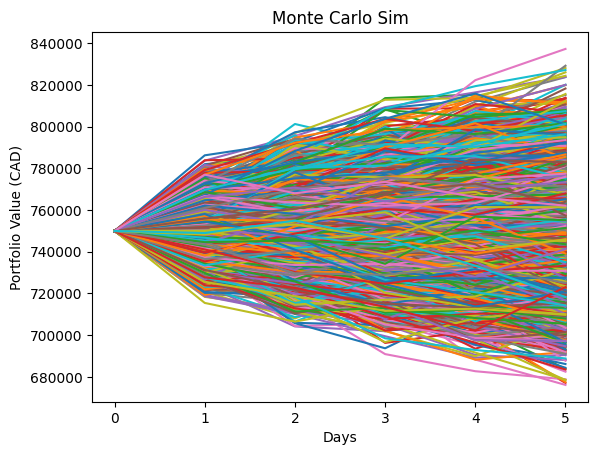

In [6]:
def generate_values():
    while True:
      # Generate nine random values within the limits
      values = np.random.uniform(0.05, 0.20, 9)
      # Calculate the tenth value
      tenth_value = 1 - values.sum()
      # Check if the tenth value is within the specified range
      if 0.05 <= tenth_value <= 0.2:
            # Append the tenth value to the list and return
            values = np.append(values, tenth_value)
            return values

# From Jan 1 - Oct 31, 2023
close = pd.DataFrame() # Final DataFrame
for stock in corr_stocks:
    tick = yf.Ticker(stock[:-6])
    chosen_ticker_list.append(stock[:-6])
    stock_hist = tick.history(start=start_date, end=end_date)
    stock_hist.index = pd.DatetimeIndex(stock_hist.index).tz_localize(None, ambiguous='infer').tz_localize('UTC').date
    if tick.history_metadata['currency'] == 'USD':
        stock_convert = pd.concat([stock_hist.Close, usd_cad_hist.Close], join = 'inner', axis = 1)
        stock_convert.columns = ['Close', 'Close_usd_cad']
        stock_hist['Close Cad'] = stock_convert['Close'] * stock_convert['Close_usd_cad']
        close[f"{stock}"] = stock_hist['Close Cad']
    else:
        close[f"{stock}"] = stock_hist['Close']
close_pct = close.pct_change()
mean_close = close_pct.mean()
cov_close = close_pct.cov() 

transaction_fee = 4.95
num_stocks = 10

# Calculating the available money for purchasing stocks after deducting transaction fees
money_to_purchase = 750000 - transaction_fee * num_stocks

# Number of Monte Carlo simulations
mc_sims = 10000

# Setting up variables related to time and stock data
days = 5  # Number of days for simulation
# Creating an array filled with mean_close values for Monte Carlo simulations
mc_mean = np.full(shape=(days, len(mean_close)), fill_value=mean_close)
mc_mean = mc_mean.T  # Transposing the array for calculation purposes

# Initializing variables for tracking the best portfolio
max_value = money_to_purchase  # Maximum portfolio value initialized with available money
max_weights = np.zeros(len(mean_close))  # Initial weights for the best portfolio

# Initializing an array to store simulated portfolio values
portfolio_sims = np.zeros((mc_sims, days))

# Loop to find the best portfolio with sum of weights equal to 1 and removes chance of a small calculation error
while sum(max_weights) != 1:
      for sim in range(mc_sims):
        # Generating random weights for the portfolio each sim
        weights = pd.Series((i for i in generate_values()))

        # Initializing portfolio value with available money for purchase
        portfolio_value = money_to_purchase
        # Simulating portfolio performance for each day
        for day in range(days):
            # Generating daily returns based on multivariate normal distribution
            daily_returns = np.random.multivariate_normal(mean_close, cov_close)
            daily_return = np.dot(weights, daily_returns)

            # Calculating portfolio value at the end of each day
            portfolio_value *= (1 + daily_return)
            portfolio_sims[sim, day] = portfolio_value

            # Updating the best portfolio if a better one is found (taken abs because we want the max diff)
            if abs(money_to_purchase - portfolio_value) > abs(money_to_purchase - max_value):
                max_value = portfolio_value
                max_weights = weights.copy() # Updating the best weights for the portfolio

print(f"Maximum portfolio value achieved: {max_value}")
print(f"Corresponding optimal weights: {max_weights}")
print(f"Sum: {sum(max_weights)}")

portfolio_sims = portfolio_sims.T
# All portfolios start at the same value
start_value = [money_to_purchase] * mc_sims

# Creates a new array for the starting values
start_row = np.array([start_value])

# Concatenate the new row with the existing array
portfolio_sims = np.concatenate((start_row, portfolio_sims), axis=0)


# Graph the Monte Carlo Simulation 
plt.plot(portfolio_sims)
plt.title('Monte Carlo Sim')
plt.xlabel('Days')
plt.ylabel('Portfolio Value (CAD)')
plt.show()

This Monte Carlo simulation is used to find the portfolio composition (weights of different stocks) that potentially maximizes the value of the portfolio over a 5-day period under various simulated market conditions. The randomness in the daily returns, introduced by sampling from a multivariate normal distribution, captures the essence of Monte Carlo methods by incorporating uncertainty and variability in market behavior. This allowed us to simulate returns of potential portfolios that contain stocks with random weights by putting them into a simulated market. This simulated market uses past trends of each stock and the covariance between them to generate possible daily returns for each stock which when combined gives us the potential portfolio returns for a 5-day period. 

As seen in the graph above after running 10000 Monte Carlo simulations a lot of the lines are bunched together, with a few outliers. These outliers show that there is a small chance that the market may move in a way that with the given weights we'll make/lose a lot of money. We will bet on this as this seems to be the riskiest option.


In [7]:

# Final portfolio
Portfolio_Final = pd.DataFrame()

weights = max_weights.tolist()

Portfolio_Final['Ticker'] = chosen_ticker_list
Portfolio_Final.index = range(1, len(Portfolio_Final) + 1)
Portfolio_Final['Price'] = "" 
Portfolio_Final['Currency'] = 'CAD' #We convert everything to CAD
Portfolio_Final['Shares'] = "" 
Portfolio_Final['Value'] = "" #Create empty columns first

#Fill in stock values using their weights
for i in range((len(weights))):
    Portfolio_Final.iloc[i,4] = money_to_purchase * weights[i]

Portfolio_Final['Weight'] = weights

portfolio_purchase_date = '2023-11-24'
day_after_date = datetime.now() #Used as end date in order to extract purchase date

exchange_rate_purchase_date = usd_cad_tick.history(start = portfolio_purchase_date, end = day_after_date).iloc[0,3]

#Fill in price of stocks and number of shares purchased on November 25
for i in range(len(chosen_ticker_list)):
    tick = yf.Ticker(chosen_ticker_list[i])
    stock_hist = tick.history(start = portfolio_purchase_date, end = day_after_date)

    if tick.history_metadata['currency'] == 'USD':
        Portfolio_Final.iloc[i,1] = stock_hist.iloc[0,3] * exchange_rate_purchase_date
    else:
        Portfolio_Final.iloc[i,1] = stock_hist.iloc[0,3]
    Portfolio_Final.iloc[i,3] = Portfolio_Final.iloc[i,4] / Portfolio_Final.iloc[i,1] #Number of shares is value / price per share


print("The total is $",Portfolio_Final['Value'].sum()+transaction_fee*num_stocks, sep = "")
print("The total weights sum to ", Portfolio_Final['Weight'].sum()*100,"%",sep="")
Portfolio_Final.head(10)

The total is $750000.0000000001
The total weights sum to 100.0%


,Ticker,Price,Currency,Shares,Value,Weight
1,SHOP.TO,96.260002,CAD,1359.797502,130894.110407,0.174537
2,AMZN,200.960444,CAD,724.945335,145685.336116,0.194260
3,PYPL,76.36332,CAD,846.595747,64648.861941,0.086204
4,AAPL,260.163924,CAD,231.349774,60188.865047,0.080257
5,BLK,999.871947,CAD,78.725263,78715.18241,0.104961
6,QCOM,174.95363,CAD,382.422767,66906.251435,0.089214
7,TXN,210.341506,CAD,209.113158,43985.176652,0.058651
8,AXP,225.173194,CAD,253.109737,56993.528061,0.075996
9,TD.TO,83.349998,CAD,681.735978,56822.692689,0.075769
10,UPS,208.20509,CAD,216.663749,45110.495241,0.060151


In [8]:
# Export the DataFrame to a CSV file
Stocks_Final = pd.DataFrame()
Stocks_Final['Ticker'] = Portfolio_Final['Ticker']
Stocks_Final['Shares'] = Portfolio_Final['Shares']
Stocks_Final.to_csv('Stocks_Group_17.csv')

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here. Pavel, Rachel, Timo